
## Fundamentals of ML
### Convolutional neural networks

<br />
November 26, 2024

Source for inspiration: https://github.com/andriygav/MachineLearningSeminars/tree/master/sem15

Video (in Russian): https://www.youtube.com/watch?v=_zhKsIze8QU

### Import libraries

In [1]:
!pip install lime

# Novel explanation technique that explains the predictions of any classifier in an interpretable and faithful manner
# https://arxiv.org/abs/1602.04938


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits import mplot3d
from matplotlib import gridspec
from PIL import Image
import io
from urllib.request import urlopen
from lime import lime_image
from skimage.segmentation import mark_boundaries

from tqdm.notebook import tqdm
import numpy as np
import requests
import torch

from sklearn.metrics import classification_report
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu")
device

device(type='mps')

### Convolutional neural network

In [5]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    model.zero_grad()
    
    output = model(x_batch.to(device))
    
    loss = loss_function(output, y_batch.to(device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [6]:
def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x.to(device), batch_of_y.to(device), optimizer, loss_function)
        
        if callback is not None:
            callback(model, batch_loss)
            
        epoch_loss += batch_loss * len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss / total


In [7]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            optimizer,
            lr = 0.001,
            callback=None):

    optima = optimizer(model.parameters(), lr=lr)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True), 
            leave=False, total=len(dataset)//batch_size + (len(dataset)%batch_size > 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

### Lekun, Bottou, Bengio, Haffner (1998)

<div align="center">
    <p> </p>
    <img src="./images/LeNet.jpg" alt="LeNet" width=1000 />
</div>


In [8]:
class CNN(torch.nn.Module):
    @property
    def device(self):
        for p in self.parameters():
            return p.device
        
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layers = torch.nn.Sequential()
        self.layers.add_module('conv1', torch.nn.Conv2d(in_channels=3, out_channels=1*6, kernel_size=5)) # in_channels=1 for gray scale
        self.layers.add_module('relu1', torch.nn.ReLU())
        self.layers.add_module('pool1', torch.nn.MaxPool2d(kernel_size=2))
        self.layers.add_module('conv2', torch.nn.Conv2d(1*6, 1*16, kernel_size=5))
        self.layers.add_module('relu2', torch.nn.ReLU())
        self.layers.add_module('pool2', torch.nn.MaxPool2d(kernel_size=2))
        self.layers.add_module('flatten', torch.nn.Flatten())
        self.layers.add_module('linear1', torch.nn.Linear(16*5*5, 120))
        self.layers.add_module('relu3', torch.nn.ReLU())
        self.layers.add_module('linear2', torch.nn.Linear(120, 84))
        self.layers.add_module('relu4', torch.nn.ReLU())
        self.layers.add_module('linear3', torch.nn.Linear(84, 10))

    def forward(self, input):
        return self.layers(input)

### Dataset

In [9]:
CIFAR10_train = datasets.CIFAR10('./cifar10', train=True, download=True, 
                             transform=transforms.ToTensor())

CIFAR10_test = datasets.CIFAR10('./cifar10', train=False, download=True,
                            transform=transforms.ToTensor())

100%|██████████| 170498071/170498071 [01:16<00:00, 2215781.00it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [10]:
CIFAR10_labels_map = dict(
    zip(range(10),
    ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    )

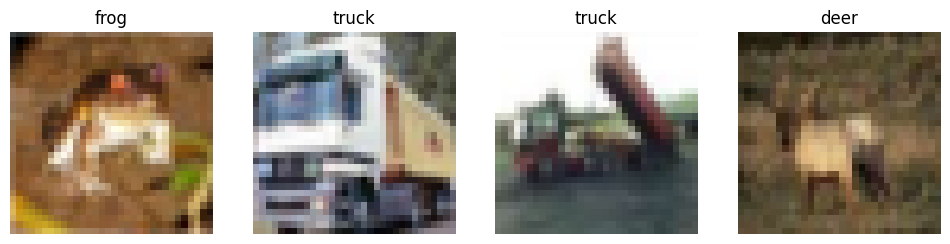

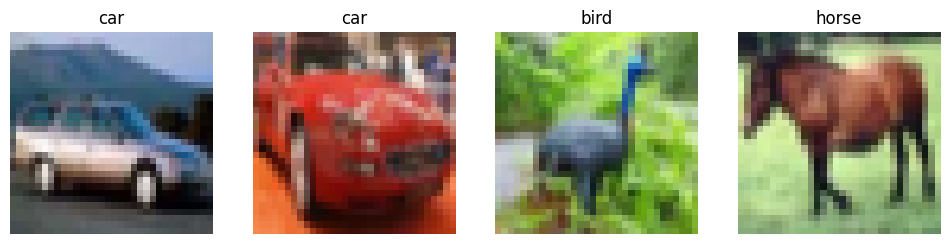

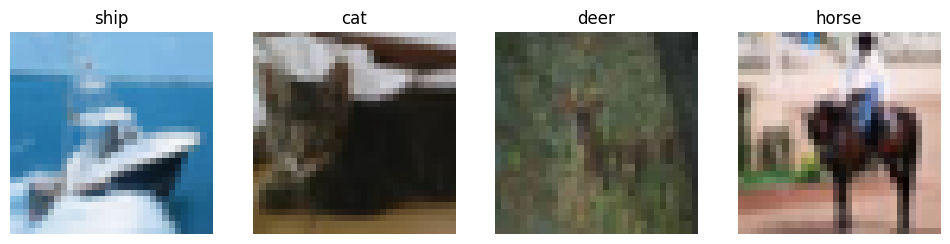

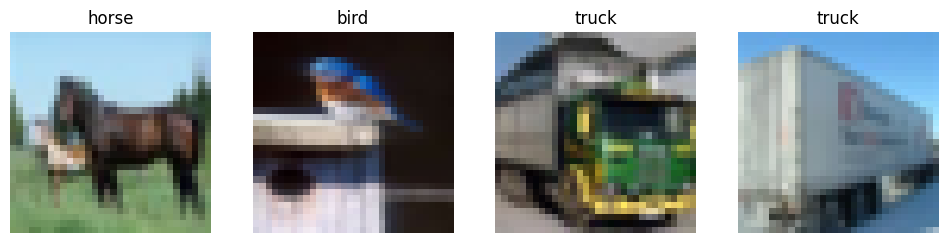

In [11]:
batch_generator = torch.utils.data.DataLoader(dataset=CIFAR10_train, batch_size=4)
it = iter(batch_generator)

cols = 4
for rows in range(1, 5):
    imgs, labels = next(it)
    
    figure = plt.figure(figsize=(12, 12))
    
    i = 1
    for img, label in zip(imgs, labels):
        figure.add_subplot(rows, cols, i)
        i += 1
        plt.title(CIFAR10_labels_map[label.item()])
        plt.axis("off")
        plt.imshow(torch.moveaxis(img.squeeze(), 0, 2))

plt.show()

### Model initialization

In [12]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

model = CNN()
model.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=400, out_features=120, bias=True)
    (relu3): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Before training

In [13]:
batch_generator = torch.utils.data.DataLoader(dataset=CIFAR10_test, batch_size=64)
            
pred = []
real = []
test_loss = 0
for it, (x_batch, y_batch) in enumerate(batch_generator):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    with torch.no_grad():
        output = model(x_batch)

    test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)

    pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

test_loss /= len(CIFAR10_test)

print('loss: {}'.format(test_loss))

loss: 2.3046127269744874


### Layers visualization

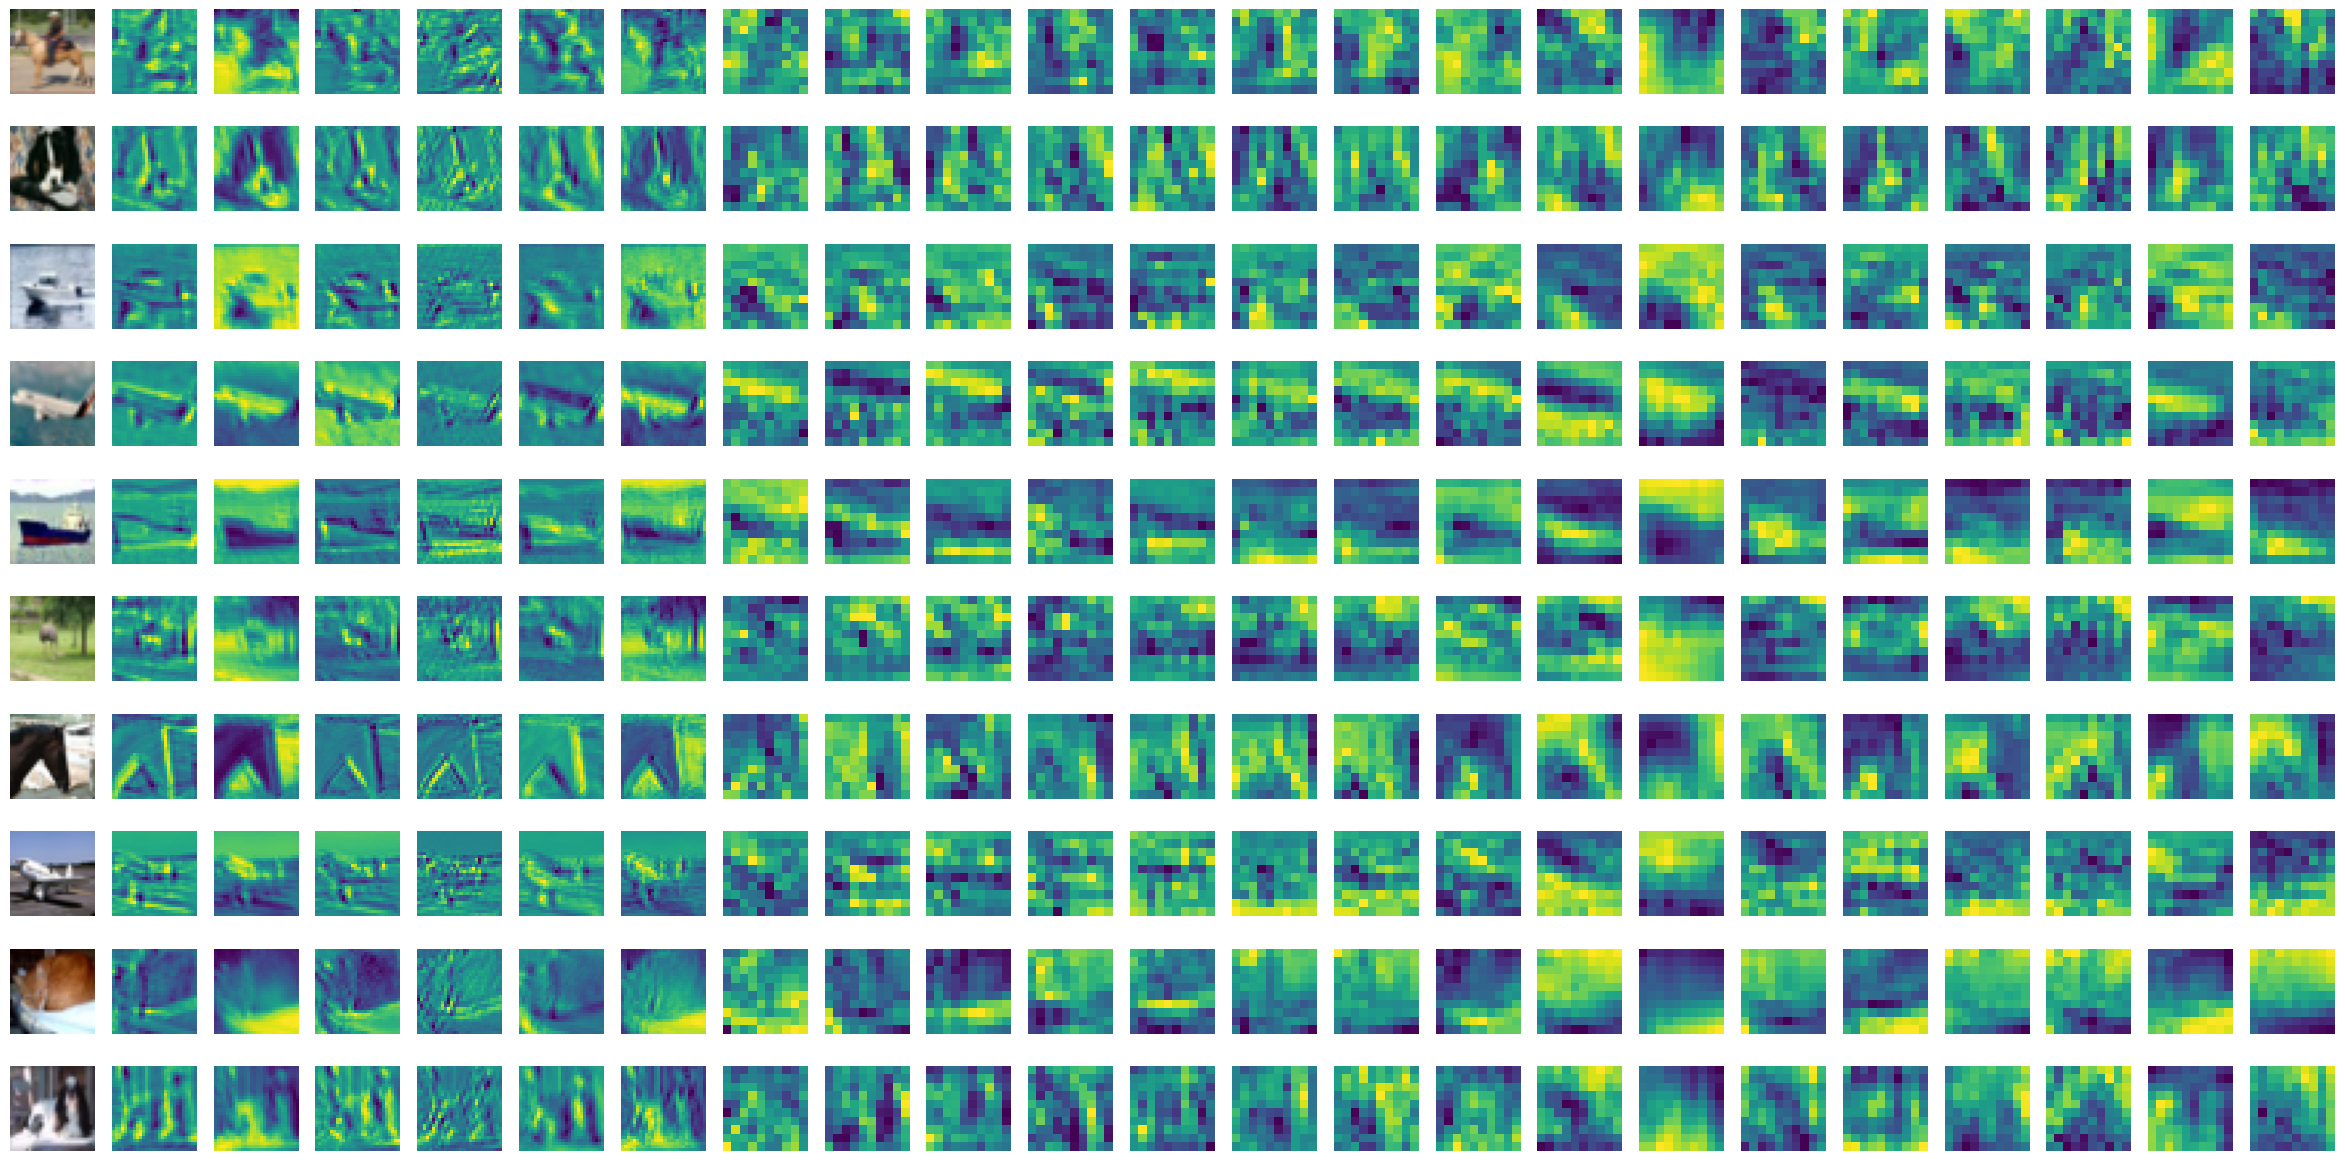

In [14]:
x = x_batch[:10]
y = model.layers.conv1(x)
z = model.layers.conv2(model.layers.pool1(model.layers.relu1(y)))

fig = plt.figure(figsize=(30, 15))
gs = gridspec.GridSpec(10, 23)
ax = np.empty([10, 23], dtype=object)
for i in range(10):
    for j in range(23):
        ax[i][j] = fig.add_subplot(gs[i, j])
for i in range(len(x)):
    ax[i][0].imshow(np.moveaxis(x.cpu().data[i].numpy(), 0, 2))
    ax[i][0].axis("off")
    for j in range(1, 7):
        ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
        ax[i][j].axis("off")

    for j in range(7, 23):
        ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
        ax[i][j].axis("off")

### Model training

In [15]:
trainer(count_of_epoch=200,
        batch_size=64,
        dataset=CIFAR10_train,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        lr=0.001,
        callback=None)

epoch:   0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

### After the training

In [16]:
batch_generator = torch.utils.data.DataLoader(dataset=CIFAR10_test, batch_size=64)
pred = []
real = []
test_loss = 0
for it, (x_batch, y_batch) in enumerate(batch_generator):
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    with torch.no_grad():
        output = model(x_batch)

    test_loss += loss_function(output, y_batch).cpu().item()*len(x_batch)

    pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
    real.extend(y_batch.cpu().numpy().tolist())

test_loss /= len(CIFAR10_test)

print('loss: {}'.format(test_loss))

loss: 2.4168826210021974


### Layers visualization

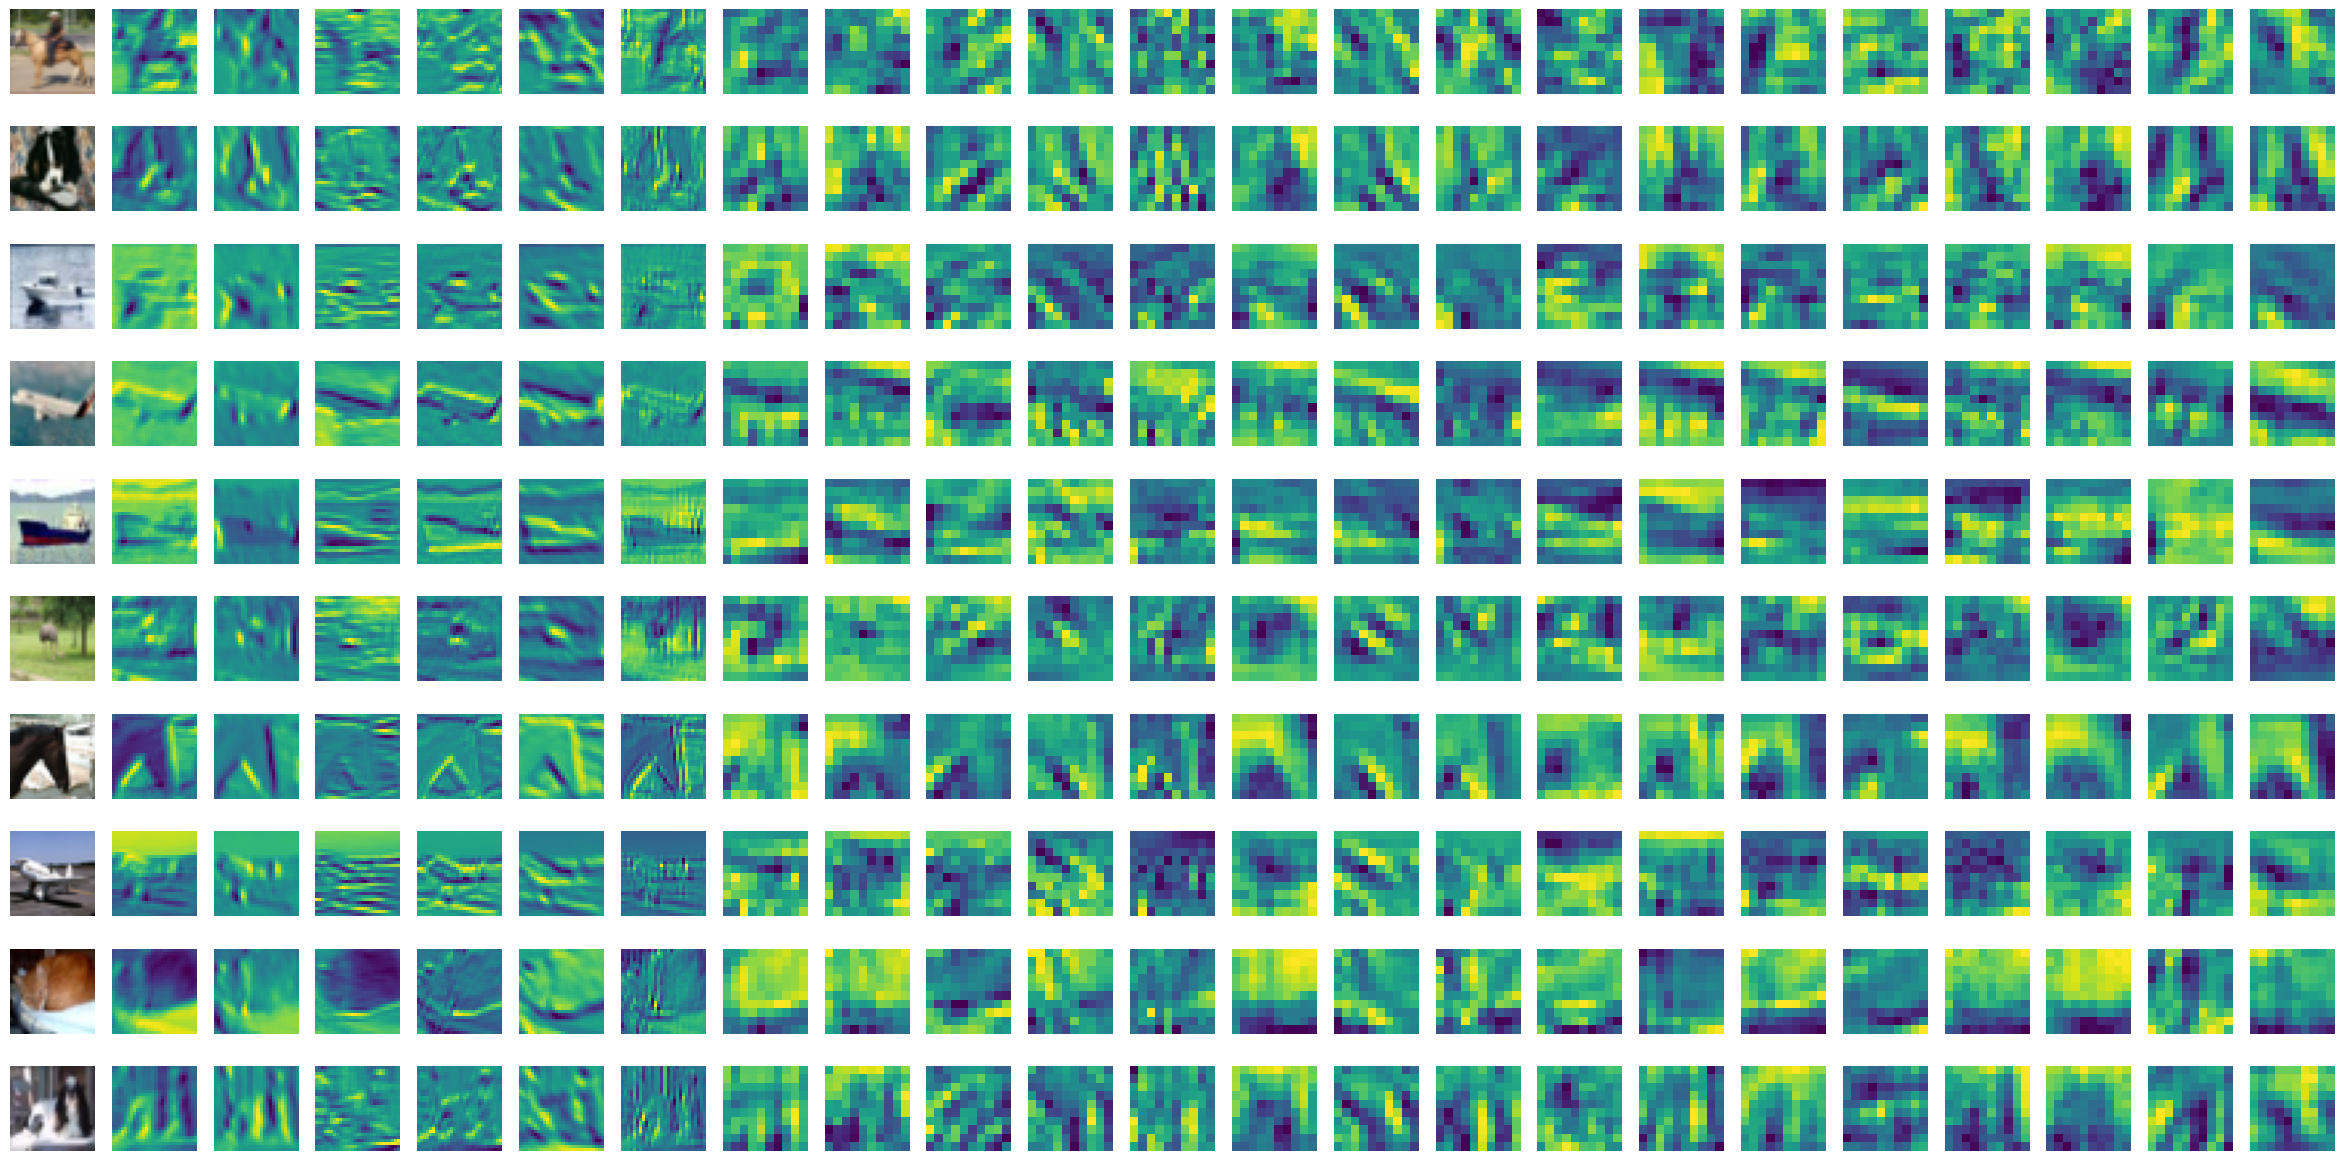

In [17]:
x = x_batch[:10]
y = model.layers.conv1(x)
z = model.layers.conv2(model.layers.pool1(model.layers.relu1(y)))

fig = plt.figure(figsize=(30, 15))
gs = gridspec.GridSpec(10, 23)
ax = np.empty([10, 23], dtype=object)
for i in range(len(x)):
    for j in range(23):
        ax[i][j] = fig.add_subplot(gs[i, j])
for i in range(len(x)):
    ax[i][0].imshow(np.moveaxis(x.cpu().data[i].numpy(), 0, 2))
    ax[i][0].axis("off")
    for j in range(1, 7):
        ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
        ax[i][j].axis("off")

    for j in range(7, 23):
        ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
        ax[i][j].axis("off")

## Tensorboardодели

In [18]:
%load_ext tensorboard
%tensorboard --logdir experiment/

Reusing TensorBoard on port 6006 (pid 65818), started 0:48:05 ago. (Use '!kill 65818' to kill it.)

In [19]:
class callback():
    def __init__(self, writer, dataset, loss_function, delimeter=100, batch_size=64):
        self.step = 0
        self.writer = writer
        self.delimeter = delimeter
        self.loss_function = loss_function
        self.batch_size = batch_size

        self.dataset = dataset

    def forward(self, model, loss):
        self.step += 1
        self.writer.add_scalar('LOSS/train', loss, self.step)
        
        if self.step % self.delimeter == 0:
            
            self.writer.add_graph(model, self.dataset[0][0].view(1,3,32,32).to(model.device))
            
            batch_generator = torch.utils.data.DataLoader(dataset = self.dataset, 
                                                          batch_size=self.batch_size)
            
            pred = []
            real = []
            test_loss = 0
            for it, (x_batch, y_batch) in enumerate(batch_generator):
                x_batch = x_batch.to(model.device)
                y_batch = y_batch.to(model.device)
                
                with torch.no_grad():
                    output = model(x_batch)

                test_loss += self.loss_function(output, y_batch).cpu().item()*len(x_batch)

                pred.extend(torch.argmax(output, dim=-1).cpu().numpy().tolist())
                real.extend(y_batch.cpu().numpy().tolist())
            
            test_loss /= len(self.dataset)
            
            self.writer.add_scalar('LOSS/test', test_loss, self.step)

            self.writer.add_text('REPORT/test', str(classification_report(real, pred)), self.step)

            x = x_batch[:10]
            y = model.layers.conv1(x.to(model.device))
            z = model.layers.conv2(model.layers.pool1(model.layers.relu1(y)))

            fig = plt.figure(figsize=(30, 15))
            gs = gridspec.GridSpec(10, 23)
            ax = np.empty([10, 23], dtype=object)
            for i in range(10):
                for j in range(23):
                    ax[i][j] = fig.add_subplot(gs[i, j])
            for i in range(len(x)):
                ax[i][0].imshow(np.moveaxis(x.cpu().data[i].numpy(), 0, 2))
                ax[i][0].axis("off")
                for j in range(1, 7):
                    ax[i][j].imshow(y.cpu().data[i, j-1].numpy())
                    ax[i][j].axis("off")

                for j in range(7, 23):
                    ax[i][j].imshow(z.cpu().data[i, j-7].numpy())
                    ax[i][j].axis("off")
            self.writer.add_figure('CNN/convs', fig, self.step)
          
    def __call__(self, model, loss):
        return self.forward(model, loss)

In [20]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam

model = CNN()
model.to(device)

CNN(
  (layers): Sequential(
    (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (linear1): Linear(in_features=400, out_features=120, bias=True)
    (relu3): ReLU()
    (linear2): Linear(in_features=120, out_features=84, bias=True)
    (relu4): ReLU()
    (linear3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [21]:
writer = SummaryWriter(log_dir='experiment')

call = callback(writer, CIFAR10_test, loss_function, delimeter=350)

In [22]:
trainer(count_of_epoch=10,
        batch_size=64,
        dataset=CIFAR10_train,
        model=model,
        loss_function=loss_function,
        optimizer=optimizer,
        lr=0.001,
        callback=call)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

## Pretrained models

### ResNet

In [23]:
from torchvision import models

model = models.resnet152(pretrained=True, progress=False)

In [24]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
input_image = Image.open(io.BytesIO(urlopen("https://github.com/pytorch/hub/raw/master/images/dog.jpg").read()))

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

model.to(device)
input_batch = input_batch.to(device)

with torch.no_grad():
    output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

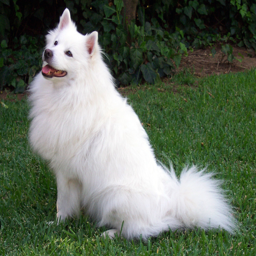

In [26]:
input_image.resize((256, 256))

In [27]:
categories = [s.strip() for s in requests.get(
    'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt').text.split('\n')]

top_prob, top_catid = torch.topk(probabilities, 3)
for i in range(top_prob.size(0)):
    print(categories[top_catid[i]], top_prob[i].item())

Samoyed 0.7907484173774719
Pomeranian 0.08977635949850082
white wolf 0.036102648824453354


## Models interpretation

In [28]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def batch_predict(input_images):
    input_tensor = torch.tensor(
        [preprocess(input_image).numpy() for input_image in input_images])
    
    input_batch = input_tensor
    input_batch = input_batch.to(device)

    output = model(input_batch)
    probs = torch.nn.functional.softmax(output, dim=-1)
    return probs.detach().cpu().numpy()

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(input_image), 
                                         batch_predict, 
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=100) # 1000


  0%|          | 0/100 [00:00<?, ?it/s]

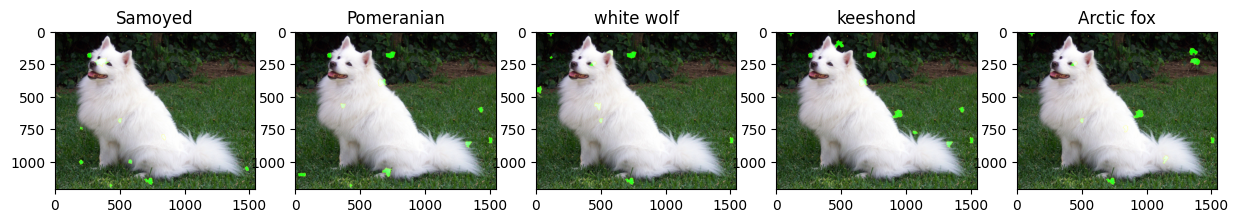

In [29]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 5)

ax = np.empty([5], dtype=object)
for i in range(5):
      ax[i] = fig.add_subplot(gs[i])

for i in range(5):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[i], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)
    img_boundry2 = mark_boundaries(temp/255.0, mask)
    ax[i].imshow(img_boundry2)
    
    ax[i].set_title(categories[explanation.top_labels[i]])

plt.show()